# For this lab, I want to create models/strategies to predict whether the value of a stock will go up or down. For this reason, I will use Random Forest Classification and K-nearest neighbours algorithm, as this is a classification problem rather than a regression problem.

# Random Forest Classification Algorithm 
# Part 1) We will start by importing all of the necessary libraries and modules

In [4]:
# i) Install yfinance (if not installed already :))
# ! pip install yfinance

# ii Import the yfinance library which contains historical data for stocks
import yfinance as yf

# iii) Import other relevant libraries and modules needed for this part
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt # for data visualisation - plots, graphs & charts
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier # module that includes two randomised decision tree algorithms; Random Forest & Extra Trees Method (we're just using Random Forest now)
from sklearn.metrics import precision_score # module for calculating the precision score (observations that the model correctly predicted out of all predictions made)
from sklearn.metrics import confusion_matrix

# Part 2) Define the ticker, create the target variable and the dataframe for visual/later usage

In [5]:
# i) Define the ticker for the specific stock we want to predict (in this case I chose Amazon)
amazon = yf.Ticker("AMZN")

# ii) Retrieve the historical data for this ticker and store to the variable
amazon  = amazon.history(period="max")

# iii) Create extra columns in order to calculate the incidences where the value went up (represented by 1) - otherwise it's 0. Then pop it in a dataframe to check how it looks.

# "Tomorrow" aligns the closing value of the current day with the open prices of the following day
amazon["Tomorrow"] = amazon["Close"].shift(-1)

# "Target" returns 1 if the value increased, 0 if it didn't increase
amazon["Target"] = (amazon["Tomorrow"]> amazon["Close"]).astype(int)

# Put the data in a dataframe
df = amazon[['Open', 'High', 'Low', 'Close', 'Tomorrow', 'Target']]
df

,Open,High,Low,Close,Tomorrow,Target
Date,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,0.086458,0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,0.085417,0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,0.081771,0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,0.071354,0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,0.069792,0
...,...,...,...,...,...,...
2023-12-04 00:00:00-05:00,145.250000,145.350006,142.809998,144.839996,146.880005,1
2023-12-05 00:00:00-05:00,143.550003,148.570007,143.130005,146.880005,144.520004,0
2023-12-06 00:00:00-05:00,147.580002,147.850006,144.279999,144.520004,146.880005,1


# Part 3) Check whether the data needs cleaning and check for null values

In [6]:
# i) The data coming in from yfinance is real-time and is already cleaned, but we can check our new columns for null values (there is only one in the 'Tomorrow' column)
df.isna().sum()

# ii) We can drop the sample with the null value
df.isna().sum()


Open        0
High        0
Low         0
Close       0
Tomorrow    1
Target      0
dtype: int64

# Part 4 - Create the model and split the dataset into two for training and testing

In [7]:
# i) start creating our model and defining our train and test datasets

# defining the n_estimators value means tuning our parameters aka the number of trees we want to build. The higher the better, but the slower the model
# min_samples_split evaluates the number of samples in the node. if the sample number is less than 100, then it does not split and the node will become a leaf
# random_state set to 1 results in a fixed dataset/will produce the same split
rf_model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

# train_set contains all values up until the last 100, test_set is the last 100 values
train_set = amazon.iloc[:-100]
test_set = amazon.iloc[-100:]

# define independent/predictor columns
predictor_columns = ["Close", "Volume", "Open", "High", "Low"]

# .fit() method is the training part of the model & finds the coefficients for the equation via the algorithm being used (in our case, Random Forest)
rf_model.fit(train_set[predictor_columns], train_set["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

# Part 5 - Create a prediction function that will be called to train the model on our training set, and then make predictions on our testing set

In [8]:
# i) Define the function
def predict_func(train_set, test_set, predictor_columns, rf_model):
    rf_model.fit(train_set[predictor_columns], train_set["Target"])

# ii) create variable that contains the predictions on our test set
    predictions_test = rf_model.predict(test_set[predictor_columns])

# iii) then change variable to a dataframe series
    predictions_test = pd.Series(predictions_test, index = test_set.index, name = "Predictions")

# iv) then combine the actual target values and the predicted values from the above dataframe
    combine_target_predictions = pd.concat([test_set["Target"], predictions_test], axis = 1)

    return combine_target_predictions

# Part 6 - Create a backtesting function, which creates a rolling analysis i.e. 10 years of data will be used to predict the 11th year, then 11 years will be used to predict the 12th year...and so on.

In [9]:
# i) Create the backtesting function
def backtest_func(data, rf_model, predictor_columns, start = 2500, step = 250):
    predictions_result = []

    for i in range(start, data.shape[0], step):
        train_set = data.iloc[0:i].copy()
        test_set = data.iloc[i:(i+step)].copy()

        predictions = predict_func(train_set, test_set, predictor_columns, rf_model)

        predictions_result.append(predictions)

        return pd.concat(predictions_result)

# ii) Store our backtest function in the predictions variable.
predictions = backtest_func(amazon, rf_model, predictor_columns)

# Part 7 - Now we can call the precision_score module which will give us a score of obsevations that were correctly predicted in our model. Following this, we can experiment with different values for n_estimator and min_samples_split, to see whether our model improves

In [10]:
# i) Use the prediction_score module from sklearn.metrics, which gives us a score of observations that were correctly predicted in our model

precision_score(predictions["Target"], predictions["Predictions"])

0.6190476190476191

In [11]:
# ii) Next experiment with different n_estimator_values and min_samples_split_values

n_estimators_values = [50, 100, 200]
min_samples_split_values = [2, 5, 10]

# Then iterate over different combinations
for n_estimators in n_estimators_values:
    for min_samples_split in min_samples_split_values:

        # Create and train the Random Forest model
        rf_model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=1)
        rf_model.fit(train_set[predictor_columns], train_set["Target"])
        
        # Create prediction and precision variables again
        predictions = predict_func(train_set, test_set, predictor_columns, rf_model)
        precision = precision_score(predictions["Target"], predictions["Predictions"])
        
        # Print results
        print(f'n_estimators={n_estimators}, min_samples_split={min_samples_split}, Precision={precision}')

n_estimators=50, min_samples_split=2, Precision=0.5084745762711864
n_estimators=50, min_samples_split=5, Precision=0.5263157894736842
n_estimators=50, min_samples_split=10, Precision=0.546875
n_estimators=100, min_samples_split=2, Precision=0.5172413793103449
n_estimators=100, min_samples_split=5, Precision=0.509090909090909
n_estimators=100, min_samples_split=10, Precision=0.55
n_estimators=200, min_samples_split=2, Precision=0.5483870967741935
n_estimators=200, min_samples_split=5, Precision=0.5636363636363636
n_estimators=200, min_samples_split=10, Precision=0.5483870967741935


# Part 8 - Random Forest Conclusion
# We can see that trying the above combinations for n_estimator and min_samples_split didn't produce better precision scores. Further combinations can be tried though.
# Other ways to improve the model is by experimenting with feature selection or engineering, checking for outliers, and adding more data to see what could influence the behaviour of the stock's value.


# K Nearest Neighbour Algorithm
# Part 1) Import all of the necessary libraries and modules

In [12]:
import numpy as np
import math
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython import get_ipython
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Part 2) Create our predictor variable(s)

In [74]:
# i) 'Open-Close' and 'High-Low' are our target variables
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low

# ii) Define X and Y, where X are our predictor variables and Y is our target variable (again 1 for increase and 0 for decrease)
X = df[['Open-Close', 'High-Low']]
Y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Part 3) Split our dataset for training and testing purposes

In [75]:
split_percent = 0.7
split = int(split_percent*len(df))

x_train = X[:split]
y_train = Y[:split]

x_test = X[split:]
y_test = Y[split:]

# Part 4) Determine an ideal value for k for our model

In [76]:
# i) in the next step, we will determine which value to use for k's nearest neighbours, which uses proximity to make classifications/predictions about the grouping of each individual data point. If this value is too low, it could lead to overfitting and likewise if the value is too high, it could lead to underfitting (overfitting = well trained on data but has poor performancce when new data is incoming). According to one theory, the optimal value for K is the root of the sample size (let's see what this is)
math.sqrt(len(df))


81.77407902263406

In [77]:
# ii) in order to further check whether this value is an ideal testing value for k-NN, we will plot the error rate of our target variable by the k value. Where the error rate range starts to be less volatile will be a good starting k-value.
error_rate = []
for i in range(1, 100):
    knn_lm = KNeighborsClassifier(n_neighbors = i)
    knn_lm.fit(x_train, y_train)
    pred_i = knn_lm.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

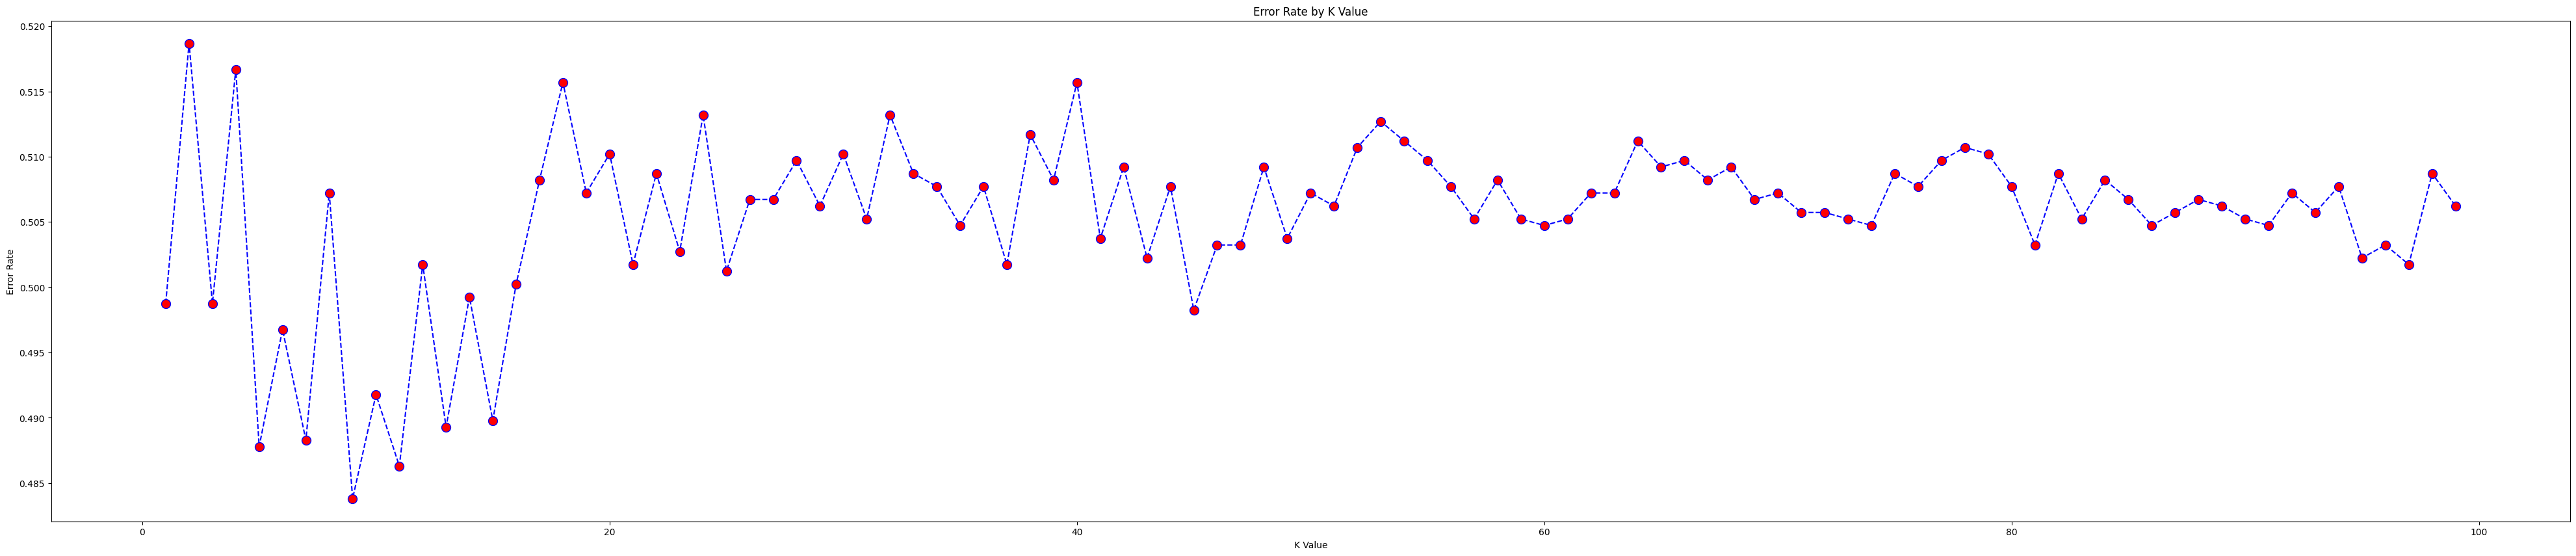

In [78]:
# iii) Plot the error rate

plt.figure(figsize=(50,10))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate by K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

# iv) We can see that the k value acts less volatile between 70-80, so quite close to the square root of our sample size. We could start by testing k = 75 (an odd value is preferred to ensure there's no ties in the voting)

# Part 5) Create the k-NN model, then run the model using our training and testing datasets, and calculate the accuracy scores for both sets

In [79]:
# i) Call for the knn learning model and state our k-value (we earlier determined 75 would be a good starting value)
knn_lm = KNeighborsClassifier(n_neighbors=75)

# ii) Fit the model
knn_lm.fit(x_train, y_train)

# iii) Create accuracy score variables for our train and test datasets
acc_score_train = accuracy_score(y_train, knn_lm.predict(x_train))
acc_score_test = accuracy_score(y_test, knn_lm.predict(x_test))

print ('Train_data Accuracy: %.2f' %acc_score_train)
print ('Test_data Accuracy: %.2f' %acc_score_test)

# iv) Result: The Test_data Accuracy tells us that 49% of the time our predictions should be correct.

Train_data Accuracy: 0.54
Test_data Accuracy: 0.49


# Part 6) Next we can create our initial trading strategy (which is just a model that predicts when we should buy or sell the given stock) and visualise the performance of actual performance vs. our strategy's performance

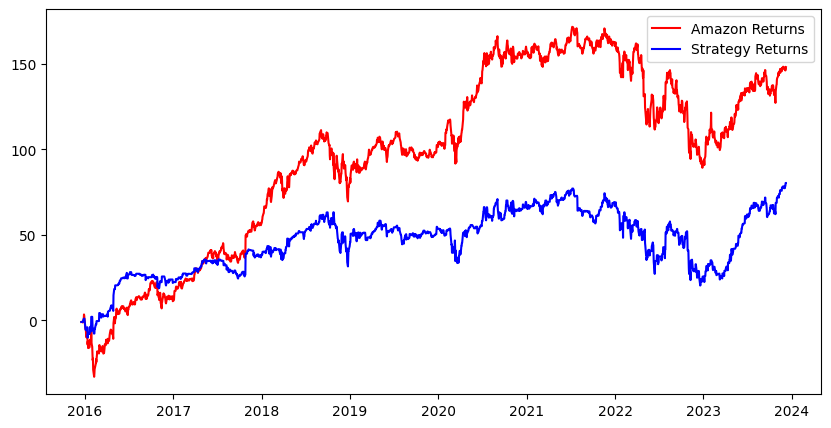

In [80]:
# i) Create prediction signal column
df['prediction_signal'] = knn_lm.predict(X)

# ii) Create a column to show the actual cumulative stock returns
df['amazon_returns_data'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_amazon_data_returns = df[split:]['amazon_returns_data'].cumsum()*100
#Cumulative_amazon_data_returns = (df[split:]['amazon_returns_data'] * df['prediction_signal'].mean()).cumsum()*100

# iii) Create a column to show our cumulative strategy returns
df['strategy_returns'] = df['amazon_returns_data']* df['prediction_signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['strategy_returns'].cumsum()*100

# iv) Plot the results to compare the performance of actual vs. strategy

plt.figure(figsize=(10,5))
plt.plot(Cumulative_amazon_data_returns, color='r',label = 'Amazon Returns')
plt.plot(Cumulative_Strategy_returns, color='b', label = 'Strategy Returns')
plt.legend()
plt.show()

# v) Result: it looks like the amazon strategy is producing better returns than our strategy, but this is because it's skewed due to our strategy not always being fully invested.

# Part 7) Lastly, we can calculate the Sharpe Ratio. The Sharpe Ratio gives us a ratio of return per unit of risk.

In [81]:
# i) We want to calculate the annual Sharpe Ratio, so we take the daily Sharpe, and multiply by the square root of trading days within a year.
sharpe_daily_actual = df[split:]['amazon_returns_data'].mean() / df[split:]['amazon_returns_data'].std() 
sharpe_annual_actual = sharpe_daily_actual * np.sqrt(252)
sharpe_annual_actual
# ii) The result tells us that for every percent we "bet", we make a 0,56% return.

0.5599030872707794

In [82]:
# iii) We do the same as for above but now for our strategy.
sharpe_daily_strategy = df[split:]['strategy_returns'].mean() / df[split:]['strategy_returns'].std()
sharpe_annual_strategy = sharpe_daily_strategy * np.sqrt(252)
sharpe_annual_strategy
# iv) The result tells us that for every percent we "bet", we make a 0,39% return.

0.3891817208763734

# Part 8 - K-NN Conclusion
# As mentioned, our strategy was not always fully invested, so this effected the amount of our returns.
# In order to improve our strategy, we could implement similar changes as with the Random Forest Classification. For example, more data and more features/feature engineering.